In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""RETAIN Model Evaluation"""
import os
import argparse
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.utils import Sequence

In [ ]:
# Define the file paths and other parameters as constants
PATH_MODEL = "/content/drive/MyDrive/MIMIC/output/Model/weights.01.hdf5"
PATH_DATA = "/content/drive/MyDrive/MIMIC/output/data_test.pkl"
PATH_TARGET = "/content/drive/MyDrive/MIMIC/output/target_test.pkl"
PATH_GRAPH = "/content/drive/MyDrive/MIMIC/output/Graphs/"
OMIT_GRAPHS = True  # Set to True or False as needed
N_STEPS = 300
BATCH_SIZE = 32

In [ ]:
def import_model(path):
    """Import model from training phase

    :param str path: path to HDF5 file
    :return: Keras model
    :rtype: :class:`tensorflow.keras.Model`
    """

    K.clear_session()
    config = tf.compat.v1.ConfigProto(
        allow_soft_placement=True, log_device_placement=False
    )
    config.gpu_options.allow_growth = True
    tfsess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(tfsess)
    model = load_model(
        path,
        custom_objects={
            "FreezePadding": FreezePadding,
            "FreezePadding_Non_Negative": FreezePadding_Non_Negative,
        },
    )

    return model

In [ ]:
def get_model_parameters(model):
    """Get model parameters of interest

    :param model: Keras model
    :type model: :class:`tensorflow.keras.Model`
    :return: parameters of model
    :rtype: :class:`ModelParameters`
    """

    class ModelParameters:
        """Helper class to store model parameters"""

        def __init__(self):
            self.num_codes = None
            self.numeric_size = None
            self.use_time = None

    params = ModelParameters()
    names = [layer.name for layer in model.layers]
    params.num_codes = model.get_layer(name="embedding").input_dim - 1
    if "numeric_input" in names:
        params.numeric_size = model.get_layer(name="numeric_input").input_shape[2]
    else:
        params.numeric_size = 0
    if "time_input" in names:
        params.use_time = True
    else:
        params.use_time = False
    return params

In [ ]:
class FreezePadding_Non_Negative(Constraint):
    """Freezes the last weight to be near 0 and prevents non-negative embeddings

    :param Constraint: Keras sequence constraint
    :type Constraint: :class:`tensorflow.keras.constraints.Constraint`
    :return: padded tensorflow tensor
    :rtype: :class:`tensorflow.Tensor`
    """

    def __call__(self, w):
        other_weights = K.cast(K.greater_equal(w, 0)[:-1], K.floatx())
        last_weight = K.cast(
            K.equal(K.reshape(w[-1, :], (1, K.shape(w)[1])), 0.0), K.floatx()
        )
        appended = K.concatenate([other_weights, last_weight], axis=0)
        w *= appended
        return w

In [ ]:
class FreezePadding(Constraint):
    """Freezes the last weight to be near 0.

    :param Constraint: Keras sequence constraint
    :type Constraint: :class:`tensorflow.keras.constraints.Constraint`
    :return: padded tensorflow tensor
    :rtype: :class:`tensorflow.Tensor`
    """

    def __call__(self, w):
        other_weights = K.cast(K.ones(K.shape(w))[:-1], K.floatx())
        last_weight = K.cast(
            K.equal(K.reshape(w[-1, :], (1, K.shape(w)[1])), 0.0), K.floatx()
        )
        appended = K.concatenate([other_weights, last_weight], axis=0)
        w *= appended
        return w

In [ ]:
def precision_recall(y_true, y_prob, graph):
    """
    Get precision recall statistics

    :param y_true: NumPy array of true target values
    :type y_true: :class:`numpy.array`
    :param y_prob: NumPy array of predicted target values
    :type y_prob: :class:`numpy.array`
    :param graph: Option to plot + save precision-recall curve
    :type graph: bool
    """

    average_precision = average_precision_score(y_true, y_prob)
    if graph:
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        plt.style.use("ggplot")
        plt.clf()
        plt.plot(
            recall,
            precision,
            label="Precision-Recall Curve  (Area = %0.3f)" % average_precision,
        )
        plt.xlabel("Recall: P(predicted+|true+)")
        plt.ylabel("Precision: P(true+|predicted+)")
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc="lower left")
        print("Precision-Recall Curve saved to pr.png")

        # Create the directory if it doesn't exist
        os.makedirs(PATH_GRAPH, exist_ok=True)

        plt.savefig(PATH_GRAPH+"pr.png")
    else:
        print("Average Precision %0.3f" % average_precision)

In [ ]:
def probability_calibration(y_true, y_prob, graph):
    """
    Get probability calibration

    :param y_true: NumPy array of true target values
    :type y_true: :class:`numpy.array`
    :param y_prob: NumPy array of predicted target values
    :type y_prob: :class:`numpy.array`
    :param graph: Option to plot + save probability calibration curves
    :type graph: bool
    """

    if graph:
        fig_index = 1
        name = "My pred"
        n_bins = 20
        fig = plt.figure(fig_index, figsize=(10, 10))
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob, n_bins=n_bins, normalize=True
        )

        ax1.plot(mean_predicted_value, fraction_of_positives, label=name)

        ax2.hist(y_prob, range=(0, 1), bins=n_bins, label=name, histtype="step", lw=2)

        ax1.set_ylabel("Fraction of Positives")
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc="lower right")
        ax1.set_title("Calibration Plots  (Reliability Curve)")

        ax2.set_xlabel("Mean predicted value")
        ax2.set_ylabel("Count")
        ax2.legend(loc="upper center", ncol=2)
        print("Probability Calibration Curves saved to calibration.png")
        plt.tight_layout()

        # Create the directory if it doesn't exist
        os.makedirs(PATH_GRAPH, exist_ok=True)

        plt.savefig(PATH_GRAPH+"calibration.png")

In [ ]:
def lift(y_true, y_prob, graph):
    """
    Get lift chart

    :param y_true: NumPy array of true target values
    :type y_true: :class:`numpy.array`
    :param y_prob: NumPy array of predicted target values
    :type y_prob: :class:`numpy.array`
    :param graph: Option to plot + save lift chart
    :type graph: bool
    """

    prevalence = sum(y_true) / len(y_true)
    average_lift = average_precision_score(y_true, y_prob) / prevalence
    if graph:
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        lift_values = precision / prevalence
        plt.style.use("ggplot")
        plt.clf()
        plt.plot(
            recall,
            lift_values,
            label="Lift-Recall Curve  (Area = %0.3f)" % average_lift,
        )
        plt.xlabel("Recall: P(predicted+|true+)")
        plt.ylabel("Lift")
        plt.xlim([0.0, 1.0])
        plt.legend(loc="lower left")
        print("Lift-Recall Curve saved to lift.png")

        # Create the directory if it doesn't exist
        os.makedirs(PATH_GRAPH, exist_ok=True)
        plt.savefig(PATH_GRAPH+"lift")
    else:
        print("Average Lift %0.3f" % average_lift)

In [ ]:
def roc(y_true, y_prob, graph):
    """
    Get ROC statistics

    :param y_true: NumPy array of true target values
    :type y_true: :class:`numpy.array`
    :param y_prob: NumPy array of predicted target values
    :type y_prob: :class:`numpy.array`
    :param graph: Option to plot + save ROC curves
    :type graph: bool
    """

    roc_auc = roc_auc_score(y_true, y_prob)
    if graph:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=2,
            label="ROC curve (Area = %0.3f)" % roc_auc,
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate (1 - Specifity)")
        plt.ylabel("True Positive Rate (Sensitivity)")
        plt.title("Receiver Operating Characteristic")
        plt.legend(loc="lower right")
        print("ROC Curve saved to roc.png")

        # Create the directory if it doesn't exist
        os.makedirs(PATH_GRAPH, exist_ok=True)

        plt.savefig(PATH_GRAPH+"roc.png")
    else:
        print("ROC-AUC %0.3f" % roc_auc)

In [ ]:
class SequenceBuilder(Sequence):
    """Class to properly construct data to sequences

    :param Sequence: Customized Sequence class for generating batches of data
    :type Sequence: :class:`tensorflow.keras.utils.data_utils.Sequence`
    """

    def __init__(self, data, model_parameters):
        # Receive all appropriate data
        self.codes = data[0]
        index = 1
        if model_parameters.numeric_size:
            self.numeric = data[index]
            index += 1

        if model_parameters.use_time:
            self.time = data[index]

        self.num_codes = model_parameters.num_codes
        self.batch_size = BATCH_SIZE
        self.numeric_size = model_parameters.numeric_size
        self.use_time = model_parameters.use_time
        self.n_steps = N_STEPS

    def __len__(self):
        """Compute number of batches.
        Add extra batch if the data doesn't exactly divide into batches
        """
        if len(self.codes) % self.batch_size == 0:
            return len(self.codes) // self.batch_size
        return len(self.codes) // self.batch_size + 1

    def __getitem__(self, idx):
        """Get batch of specific index"""

        def pad_data(data, length_visits, length_codes, pad_value=0):
            """Pad data to desired number of visits and codes inside each visit"""
            zeros = np.full((len(data), length_visits, length_codes), pad_value)
            for steps, mat in zip(data, zeros):
                if steps != [[-1]]:
                    for step, mhot in zip(steps, mat[-len(steps) :]):
                        # Populate the data into the appropriate visit
                        mhot[: len(step)] = step

            return zeros

        # Compute reusable batch slice
        batch_slice = slice(idx * self.batch_size, (idx + 1) * self.batch_size)
        x_codes = self.codes[batch_slice]
        # Max number of visits and codes inside the visit for this batch
        pad_length_visits = min(max(map(len, x_codes)), self.n_steps)
        pad_length_codes = max(map(lambda x: max(map(len, x)), x_codes))
        # Number of elements in a batch (useful in case of partial batches)
        length_batch = len(x_codes)
        # Pad data
        x_codes = pad_data(x_codes, pad_length_visits, pad_length_codes, self.num_codes)
        outputs = [x_codes]
        # Add numeric data if necessary
        if self.numeric_size:
            x_numeric = self.numeric[batch_slice]
            x_numeric = pad_data(x_numeric, pad_length_visits, self.numeric_size, -99.0)
            outputs.append(x_numeric)
        # Add time data if necessary
        if self.use_time:
            x_time = sequence.pad_sequences(
                self.time[batch_slice],
                dtype=np.float32,
                maxlen=pad_length_visits,
                value=+99,
            ).reshape(length_batch, pad_length_visits, 1)
            outputs.append(x_time)

        return outputs

In [ ]:
def read_data(model_parameters):
    """Read test data used for scoring

    :param model_parameters: parameters of model
    :type model_parameters: str
    :return: tuple for data and classifier arrays
    :rtype: tuple( list[class:`numpy.ndarray`] , :class:`numpy.ndarray`)
    """

    data = pd.read_pickle(PATH_DATA)
    y = pd.read_pickle(PATH_TARGET)["target"].values
    data_output = [data["codes"].values]

    if model_parameters.numeric_size:
        data_output.append(data["numerics"].values)
    if model_parameters.use_time:
        data_output.append(data["to_event"].values)
    return (data_output, y)

In [ ]:
def get_predictions(model, data, model_parameters):
    """Get Model Predictions

    :param model: trained Keras model
    :type model: :class:`tensorflow.keras.Model`
    :param data: array(s) for features (e.g. ['to_event_ordered','code_ordered','numeric_ordered'])
    :type data: list[class:`numpy.ndarray`]
    :param str model_parameters: parameters of model
    :return: 1-d array of scores for being in positive class
    :rtype: :class:`numpy.ndarray`
    """

    test_generator = SequenceBuilder(data, model_parameters)
    preds = model.predict_generator(
        generator=test_generator,
        max_queue_size=15,
        use_multiprocessing=True,
        verbose=1,
        workers=3,
    )
    return preds

In [ ]:
def main():
    """Main Body of the code"""
    print("Loading Model and Extracting Parameters")
    model = import_model(PATH_MODEL)
    model_parameters = get_model_parameters(model)
    print("Reading Data")
    data, y = read_data(model_parameters)
    print("Predicting the probabilities")
    probabilities = get_predictions(model, data, model_parameters)
    print("Evaluating")
    roc(y, probabilities[:, 0, -1], OMIT_GRAPHS)
    precision_recall(y, probabilities[:, 0, -1], OMIT_GRAPHS)
    lift(y, probabilities[:, 0, -1], OMIT_GRAPHS)
    probability_calibration(y, probabilities[:, 0, -1], OMIT_GRAPHS)

Loading Model and Extracting Parameters
Reading Data
Predicting the probabilities


<ipython-input-92-e0641e3deca7>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(


48/48 [==============================] - 4s 32ms/step
Evaluating
ROC Curve saved to roc.png
Precision-Recall Curve saved to pr.png
Lift-Recall Curve saved to lift.png


<ipython-input-87-3df6251b7e0f>:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


Probability Calibration Curves saved to calibration.png


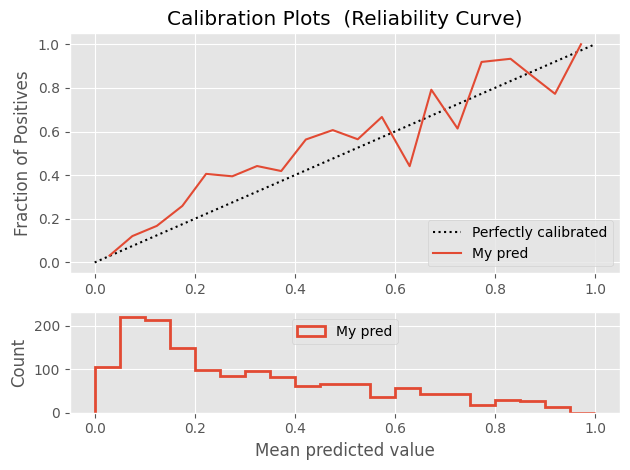

In [ ]:
main()